In [ ]:
import apebench
import exponax as ex

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import jax

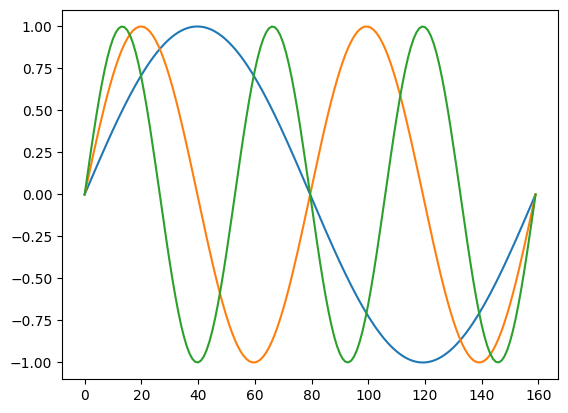

In [ ]:
x = np.linspace(0,1,160).reshape(1,-1)
for i in range(1,4):
    ic_gen = ex.ic.SineWaves1d(
                domain_extent=1.0,
                amplitudes=(1.0, ),#/ (4-i),),
                wavenumbers=(i,),
                phases=(0.0,),
                std_one=False,
                max_one=False
            )
    plt.plot(ic_gen(x).ravel())

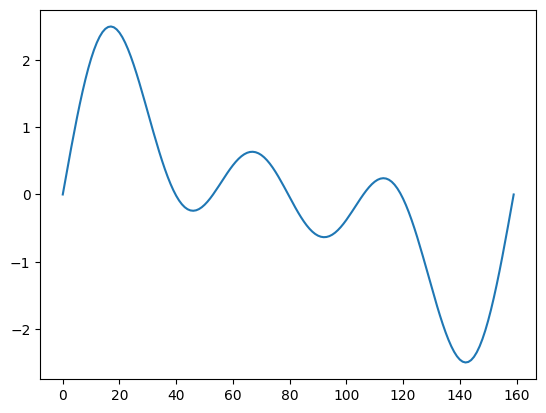

In [ ]:
ic_gen = ex.ic.SineWaves1d(
                domain_extent=1.0,
                amplitudes=(1.0, 1.0, 1.0),
                wavenumbers=(1, 2, 3),
                phases=(0.0, 0.0, 0.0),
                std_one=False,
                max_one=False
            )
plt.plot(ic_gen(x).ravel())

In [ ]:
def make_random_ic(ic_key, cutoff=2, max_one=True):
    sine_ic_gen = ex.ic.RandomSineWaves1d(num_spatial_dims=1, domain_extent=1,
                                      cutoff=cutoff, amplitude_range=(-1,1),
                                      max_one=False).gen_ic_fun(key=jax.random.PRNGKey(ic_key))

    return lambda x: sine_ic_gen(x) / (cutoff if max_one else 1.0)

def make_ic(amplitudes, phases, max_one=True):
    sine_ic_gen = ex.ic.SineWaves1d(domain_extent=1,
                                    amplitudes=amplitudes, phases=phases,
                                    wavenumbers=range(1, len(amplitudes)+1))

    return lambda x: sine_ic_gen(x) / (len(amplitudes) if max_one else 1.0)

def plot_traj_ic(traj, ic, suptitle="", maxv=3):
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3,2], figsize=(13,5))
    fig.suptitle(suptitle)
    im = ax1.imshow(traj.squeeze(1).T, cmap='coolwarm', norm=CenteredNorm(halfrange=maxv), aspect='auto')
    fig.colorbar(im, ax=ax1)
    ax2.plot(ic[0], label='IC')
    ax2.plot(traj[-1].T, label='T')
    if maxv is not None:
        ax2.set_ylim(-maxv, maxv)
    ax2.legend(loc='upper right', fontsize=6)
    fig.tight_layout()
    return fig

In [ ]:
def make_trajectory(pde, ic, g_2, g_4, d_1, n=100, scale=1):
    if pde == "KSCons":
        ks = apebench.scenarios.difficulty.KuramotoSivashinskyConservative(
            diffusion_gamma=g_2 * (scale**2),
            hyp_diffusion_gamma=g_4 * (scale**4),
            convection_delta=d_1 * scale,
            num_points=160*scale
        )
    elif pde == "KS":
        ks = apebench.scenarios.difficulty.KuramotoSivashinsky(
            diffusion_gamma=g_2 * (scale ** 2),
            hyp_diffusion_gamma=g_4 * (scale ** 4),
            gradient_norm_delta=d_1 * (scale**2),
            num_points=160 * scale
        )
    elif pde == "KdV":
        ks = apebench.scenarios.difficulty.KortewegDeVries(
            dispersion_gamma=g_2 * (scale ** 3),
            hyp_diffusion_gamma=g_4 * (scale ** 4),
            convection_sc_delta=d_1 * (scale),
            num_points=160 * scale
        )
    ks_stepper = ks.get_ref_stepper()
    traj = ex.rollout(ks_stepper, n=n)(ic)
    return traj, ks_stepper

In [ ]:
def animate_PDE(pde, g_2, g_4, d_1, ic_key=1, cutoff=3, maxv=1, scale=1, max_one=True):
    x = np.linspace(0,1,160*scale).reshape(1,-1)
    IC = make_random_ic(ic_key, cutoff=cutoff, max_one=max_one)(x)
    traj, ks = make_trajectory(pde, IC, g_2, g_4, d_1, n=400, scale=scale)
    title = " ".join([f"a_{i}={c:.2e}" for i,c in enumerate(ks.linear_coefficients) if c != 0.0])
    if hasattr(ks, "nonlinear_coefficients"):
        title += " " + " ".join([f"b_{i}={c:.2e}" for i,c in enumerate(ks.nonlinear_coefficients) if c != 0.0])
    elif hasattr(ks, "convection_scale"):
        title += f" b={ks.convection_scale:.2e}"
    else:
        title += " ?"
    if hasattr(ks, "quadratic_delta"):
        title += f" d={ks.quadratic_delta:.2e}"

    fig = plot_traj_ic(traj, IC, suptitle=title, maxv=maxv)
    return fig

def animate_IC(amplitudes, phases, stepper, max_one=False):
    x = np.linspace(0,1,stepper.num_points).reshape(1,-1)
    IC = make_ic(amplitudes, phases, max_one)(x)
    traj = ex.rollout(stepper, n=100)(IC)
    title = f"amplitudes={amplitudes}, phases={phases}"
    fig = plot_traj_ic(traj, IC, suptitle=title, maxv=None)
    return fig

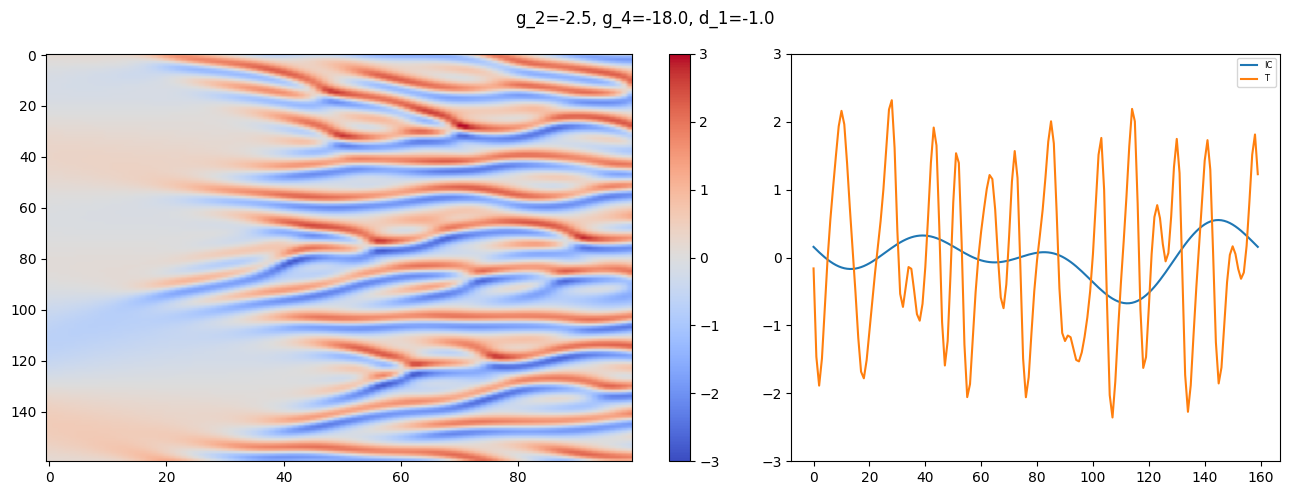

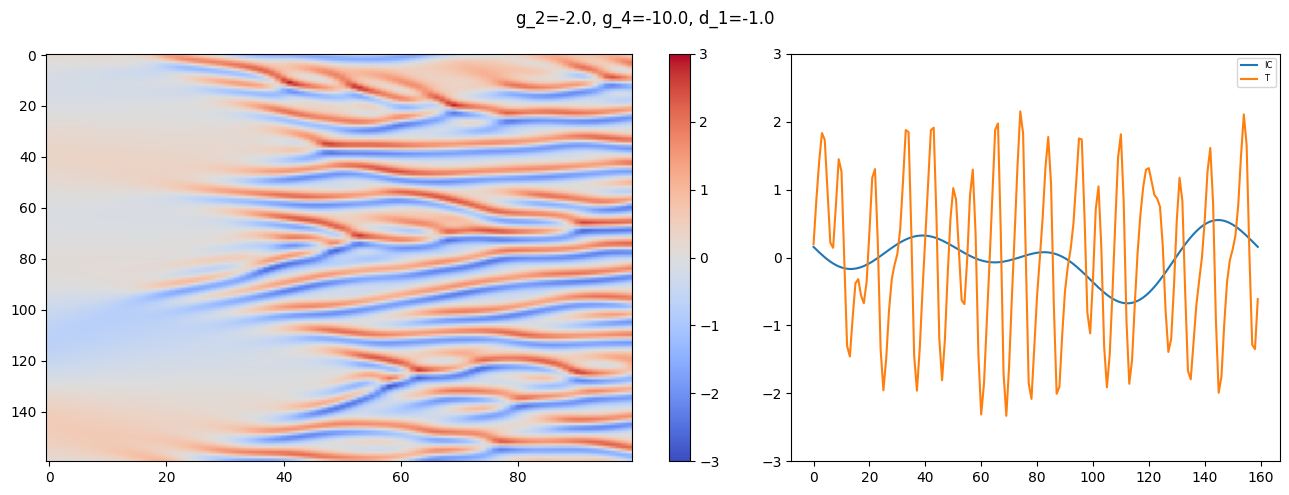

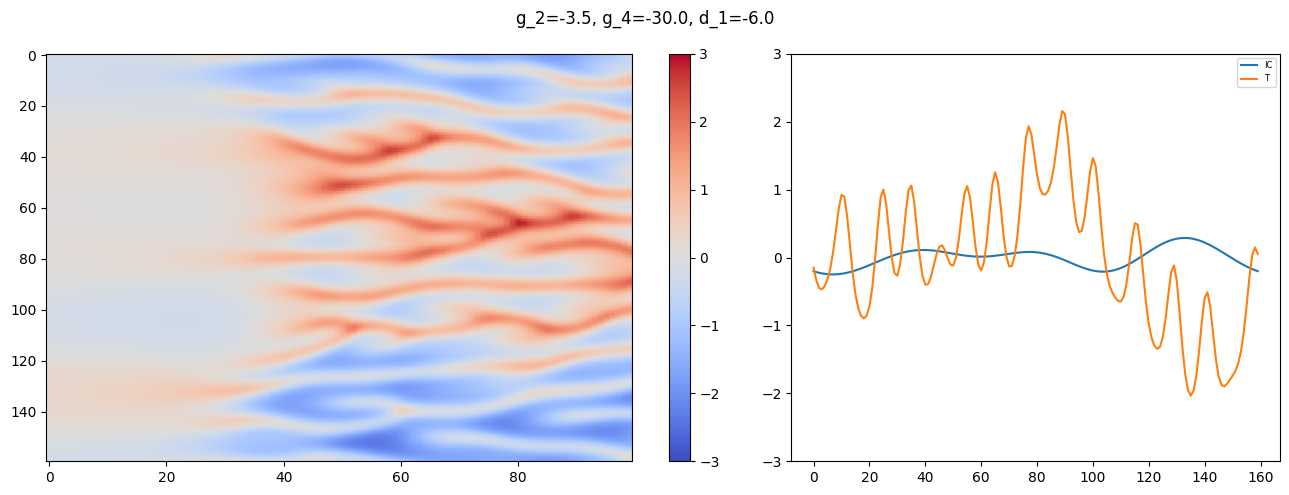

## Slider of PDE parameters (with random IC of different modes and normalisation)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

pdes = ["KSCons","KS", "KdV"]
defaults = [[-2,-18,-1], [-1.2,-15,-6], [-14,-9,-2], [0.02, 0.2, -0.02]]

# Assuming animate function is defined as in the previous response.
def make_sliders(i):

    g2_slider = widgets.FloatSlider(
        value=defaults[i][0],
        min=-20,
        max=20,
        step=0.1 if i != 3 else 0.01,
        description='g_2:',
        continuous_update=False
    )

    g4_slider = widgets.FloatSlider(
        value=defaults[i][1],
        min=-50,
        max=20,
        step=1 if i != 3 else 0.1,
        description='g_4:',
        continuous_update=False
    )

    d1_slider = widgets.FloatSlider(
        value=defaults[i][2],
        min=-10,
        max=20,
        step=0.5 if i != 3 else 0.01,
        description='d_1:',
        continuous_update=False
    )

    return g2_slider, g4_slider, d1_slider


def run_widget(PDE_ID):
    g2_slider, g4_slider, d1_slider = make_sliders(PDE_ID)

    ic_slider = widgets.IntSlider(
        value=1,
        min=1,
        max=100,
        step=1,
        description='ic_key:',
        continuous_update=False
    )

    ic_cutoff_slider = widgets.IntSlider(
        value=3,
        min=1,
        max=10,
        step=1,
        description='ic_cutoff:',
        continuous_update=False
    )
    scale_slider = widgets.IntSlider(
        value=1,
        min=1,
        max=6,
        step=1,
        description='scale:',
        continuous_update=False
    )

    max_one_slider = widgets.Checkbox(
        value=True,
        description='max_one',
        disabled=False,
        indent=False
    )

    output = widgets.Output()

    def update_plot(change):
        with output:
            clear_output(wait=True)  # Clear the previous plot
            fig = animate_PDE(
                pde=pdes[PDE_ID],
                g_2=g2_slider.value,
                g_4=g4_slider.value,
                d_1=d1_slider.value,
                ic_key=ic_slider.value,
                cutoff=ic_cutoff_slider.value,
                scale=scale_slider.value,
                maxv=3 if PDE_ID != 2 else 1,
                max_one=max_one_slider.value)
            display(fig)

    g2_slider.observe(update_plot, 'value')
    g4_slider.observe(update_plot, 'value')
    d1_slider.observe(update_plot, 'value')
    ic_slider.observe(update_plot, 'value')
    ic_cutoff_slider.observe(update_plot, 'value')
    scale_slider.observe(update_plot, 'value')
    max_one_slider.observe(update_plot, 'value')

    display(g2_slider, g4_slider, d1_slider, ic_slider, ic_cutoff_slider, scale_slider, max_one_slider, output)

    # Initial plot
    with output:
        fig = animate_PDE(pde=pdes[PDE_ID], g_2=g2_slider.value, g_4=g4_slider.value, d_1=d1_slider.value,
                      ic_key=ic_slider.value, cutoff=ic_cutoff_slider.value, scale=scale_slider.value, maxv=3 if PDE_ID != 2 else 1,
                max_one=max_one_slider.value)
        display(fig)


FloatSlider(value=-14.0, continuous_update=False, description='g_2:', max=20.0, min=-20.0)

FloatSlider(value=-9.0, continuous_update=False, description='g_4:', max=20.0, min=-50.0, step=1.0)

FloatSlider(value=-2.0, continuous_update=False, description='d_1:', max=20.0, min=-10.0, step=0.5)

IntSlider(value=1, continuous_update=False, description='ic_key:', min=1)

IntSlider(value=3, continuous_update=False, description='ic_cutoff:', max=10, min=1)

IntSlider(value=1, continuous_update=False, description='scale:', max=6, min=1)

Checkbox(value=True, description='max_one', indent=False)

Output()

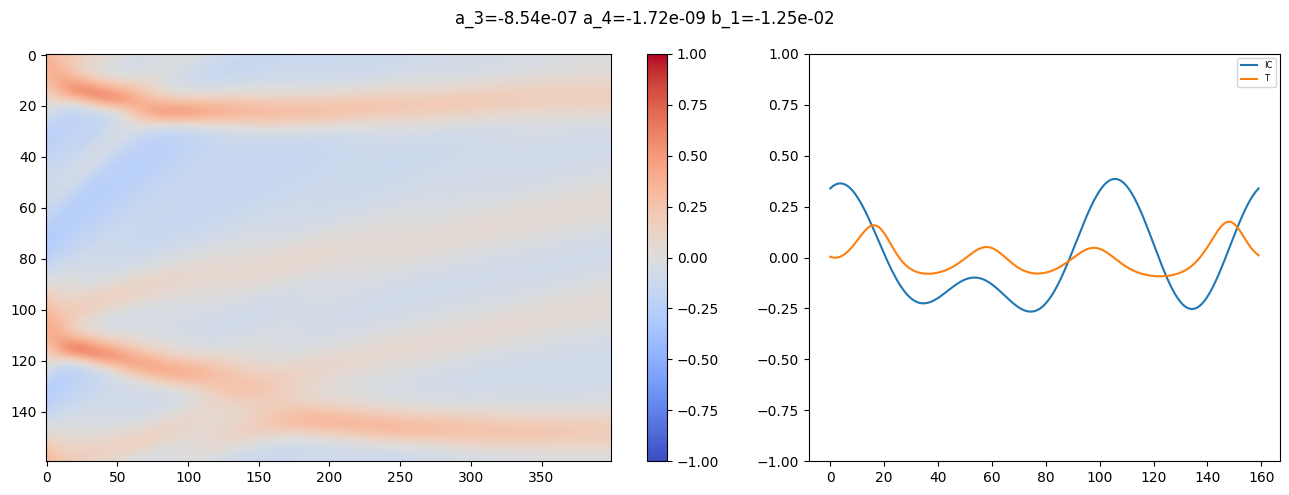

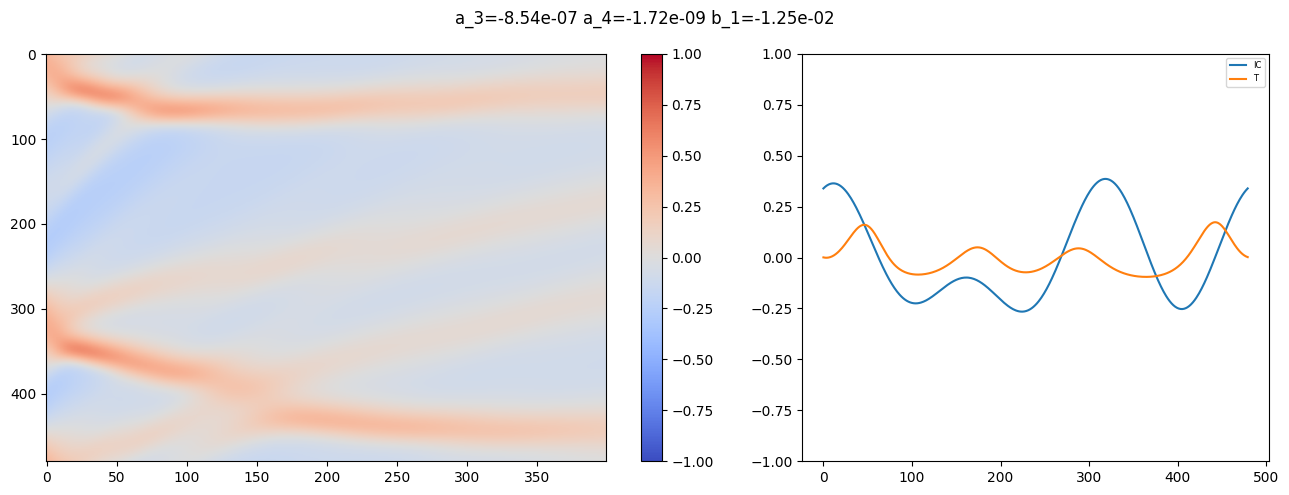

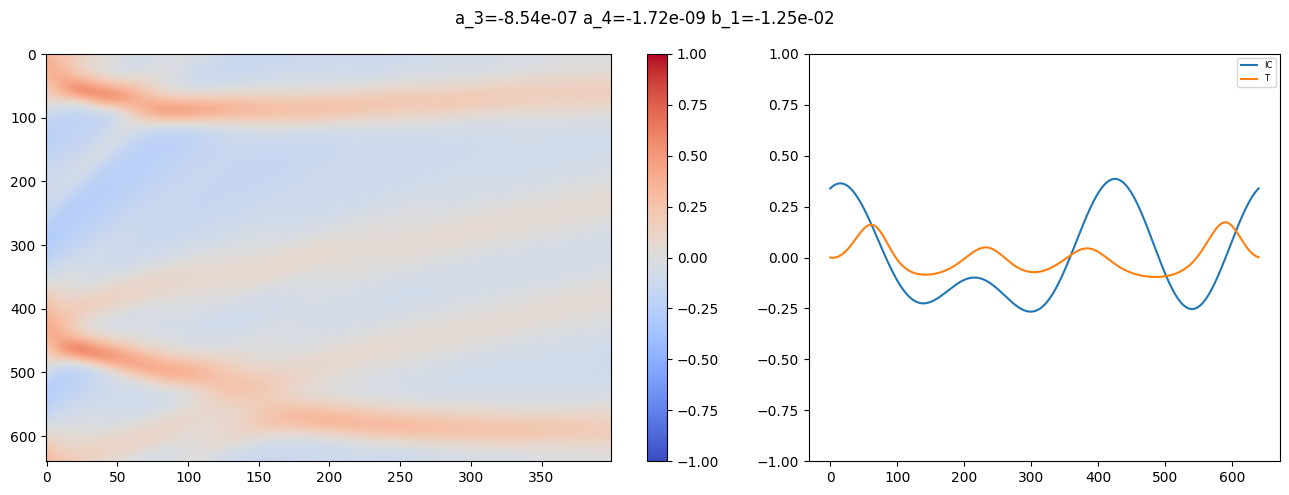

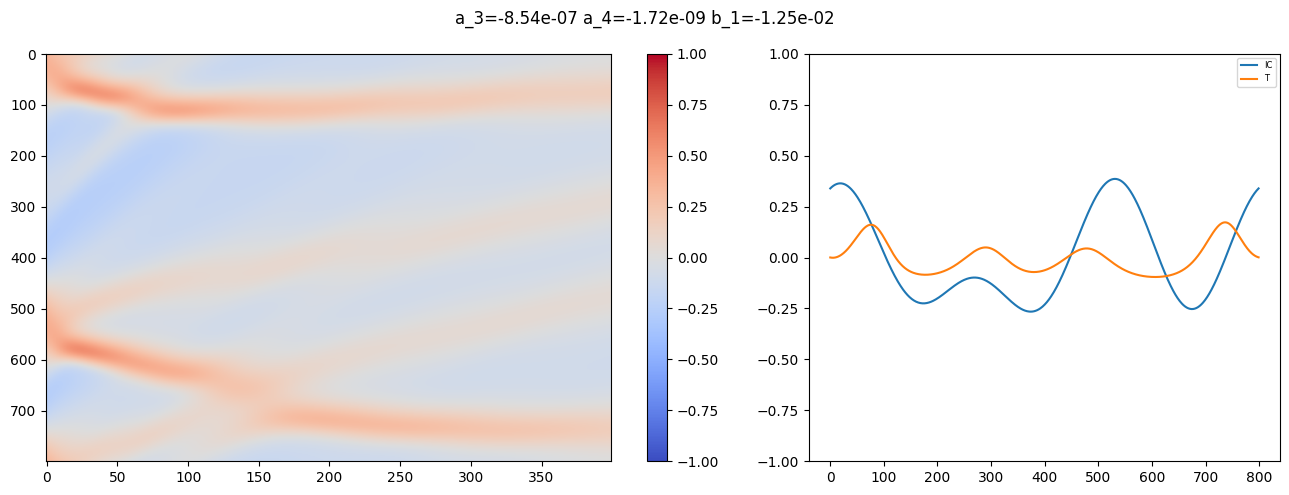

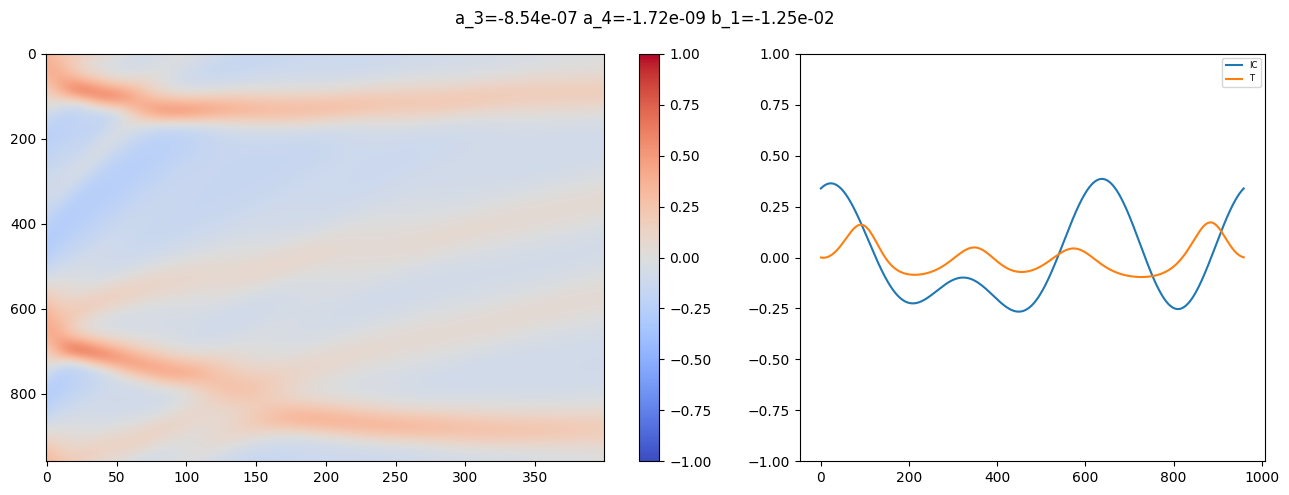

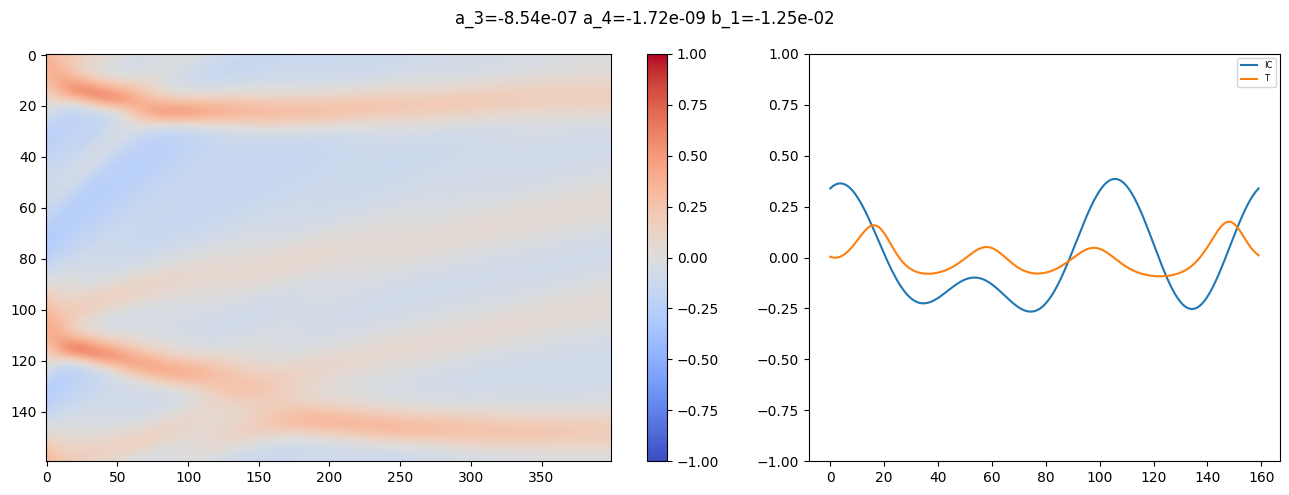

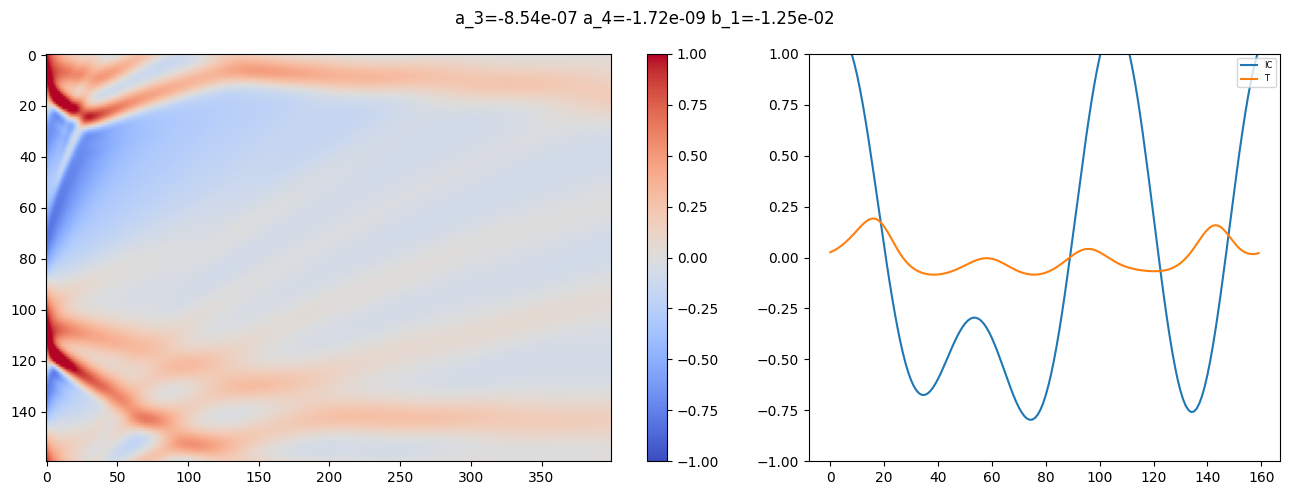

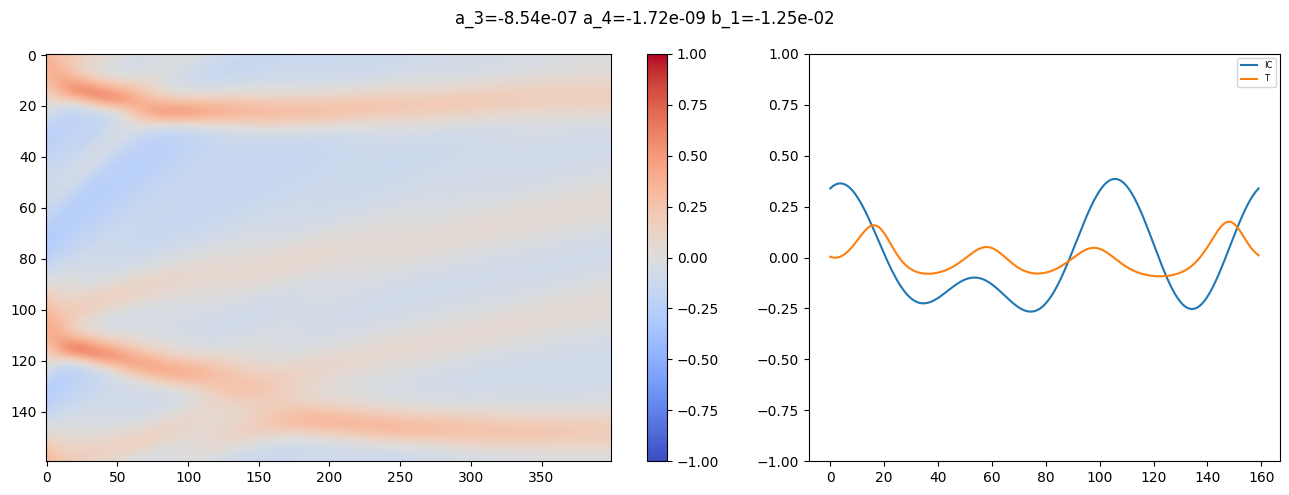

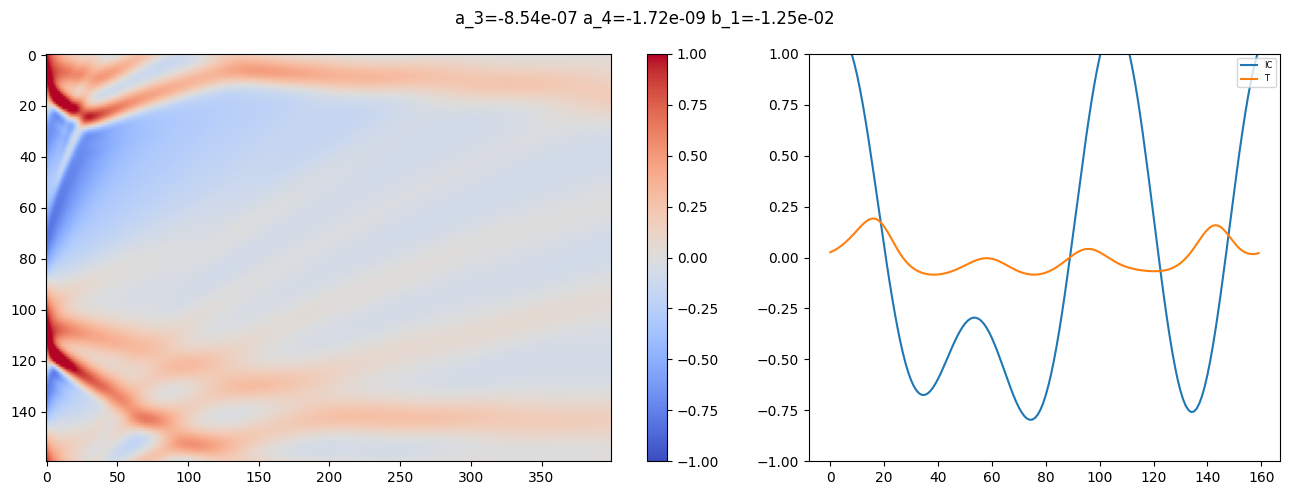

In [ ]:
run_widget(2)

## Slider of IC parameters for some PDE

In [ ]:

pdes = ["KSCons","KS", "KdV"]
defaults = [[-2,-18,-1], [-1.2,-15,-6], [-14,-9,-2]]
steppers = {
    "KSCons":
        apebench.scenarios.difficulty.KuramotoSivashinskyConservative(
            diffusion_gamma=defaults[0][0],
            hyp_diffusion_gamma=defaults[0][1],
            convection_delta=defaults[0][2]
        ).get_ref_stepper(),
    "KS":
        apebench.scenarios.difficulty.KuramotoSivashinsky(
            diffusion_gamma=defaults[1][0],
            hyp_diffusion_gamma=defaults[1][1],
            gradient_norm_delta=defaults[1][2]
        ).get_ref_stepper(),
    "KdV":
        apebench.scenarios.difficulty.KortewegDeVries(
            dispersion_gamma=defaults[2][0],
            hyp_diffusion_gamma=defaults[2][1],
            convection_sc_delta=defaults[2][2]
        ).get_ref_stepper()
}


def make_ic_sliders(N):
    Amp_sliders = []
    Phs_sliders = []
    for i in range(N):
        Amp_slider = widgets.FloatSlider(
            value=1,
            min=-1,
            max=1,
            step=0.05,
            description=f'A{i+1}:',
            continuous_update=False
        )

        phs_slider = widgets.FloatSlider(
            value=0,
            min=0,
            max=2*np.pi,
            step=2*np.pi/16,
            description=f'Phi{i+1}:',
            continuous_update=False
        )
        Amp_sliders.append(Amp_slider)
        Phs_sliders.append(phs_slider)
    return Amp_sliders, Phs_sliders

def run_widget(PDE_ID, cutoff=3):
    Amp_sliders, Phs_sliders = make_ic_sliders(cutoff)
    max_one_slider = widgets.Checkbox(
        value=True,
        description='max_one',
        disabled=False,
        indent=False
    )
    stepper = steppers[pdes[PDE_ID]]
    output = widgets.Output()

    def update_plot(change):
        with output:
            amps = tuple(slider.value for slider in Amp_sliders)
            phases = tuple(slider.value for slider in Phs_sliders)
            clear_output(wait=True)  # Clear the previous plot
            fig = animate_IC(amps, phases, stepper,max_one=max_one_slider.value)
            display(fig)

    for slider in Amp_sliders:
        slider.observe(update_plot, 'value')
    for slider in Phs_sliders:
        slider.observe(update_plot, 'value')
    max_one_slider.observe(update_plot, 'value')

    display(*Amp_sliders, *Phs_sliders, max_one_slider, output)

    # Initial plot
    with output:
        amps = tuple(slider.value for slider in Amp_sliders)
        phases = tuple(slider.value for slider in Phs_sliders)
        clear_output(wait=True)  # Clear the previous plot
        fig = animate_IC(amps, phases, stepper,max_one=max_one_slider.value)
        display(fig)


FloatSlider(value=1.0, continuous_update=False, description='A1:', max=1.0, min=-1.0, step=0.05)

FloatSlider(value=1.0, continuous_update=False, description='A2:', max=1.0, min=-1.0, step=0.05)

FloatSlider(value=0.0, continuous_update=False, description='Phi1:', max=6.283185307179586, step=0.39269908169…

FloatSlider(value=0.0, continuous_update=False, description='Phi2:', max=6.283185307179586, step=0.39269908169…

Checkbox(value=True, description='max_one', indent=False)

Output()

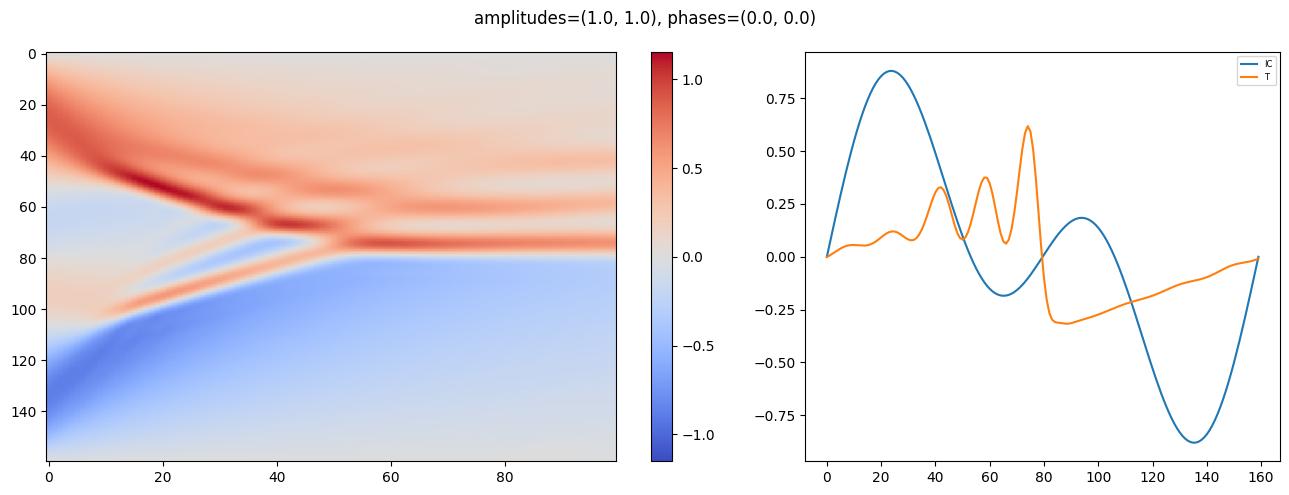

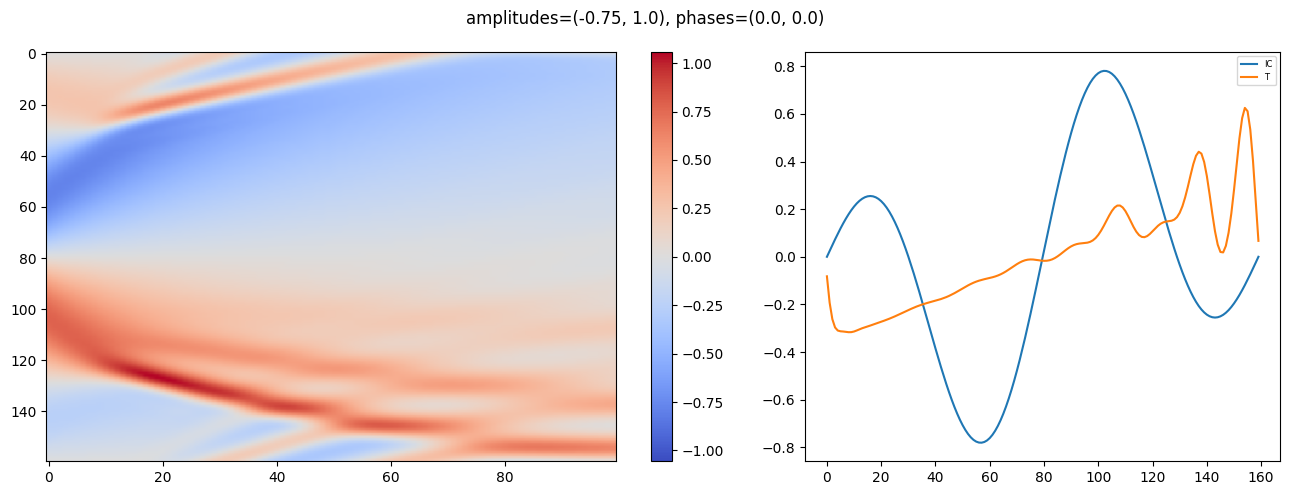

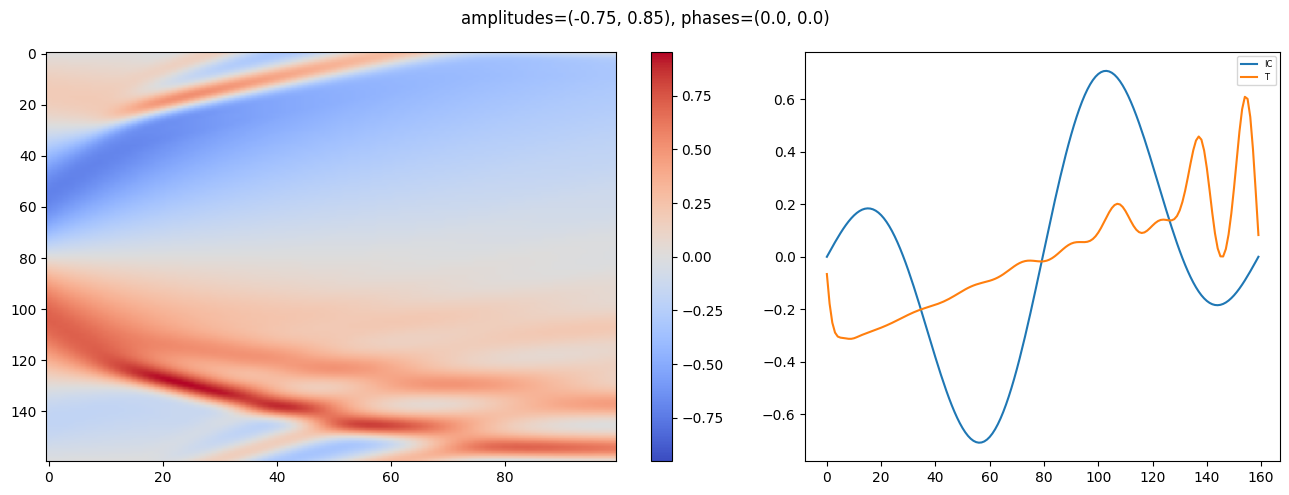

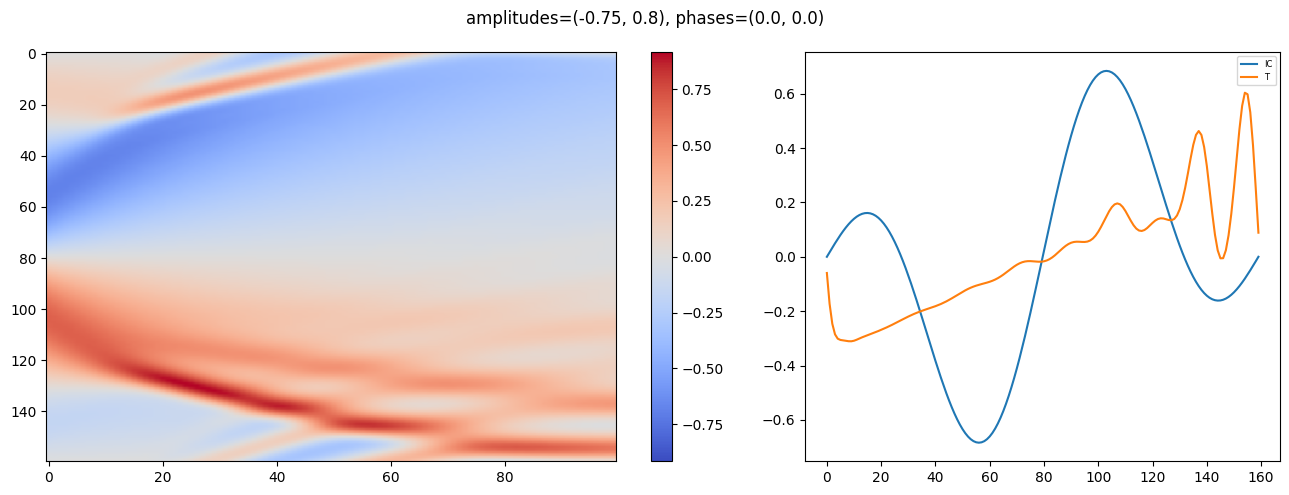

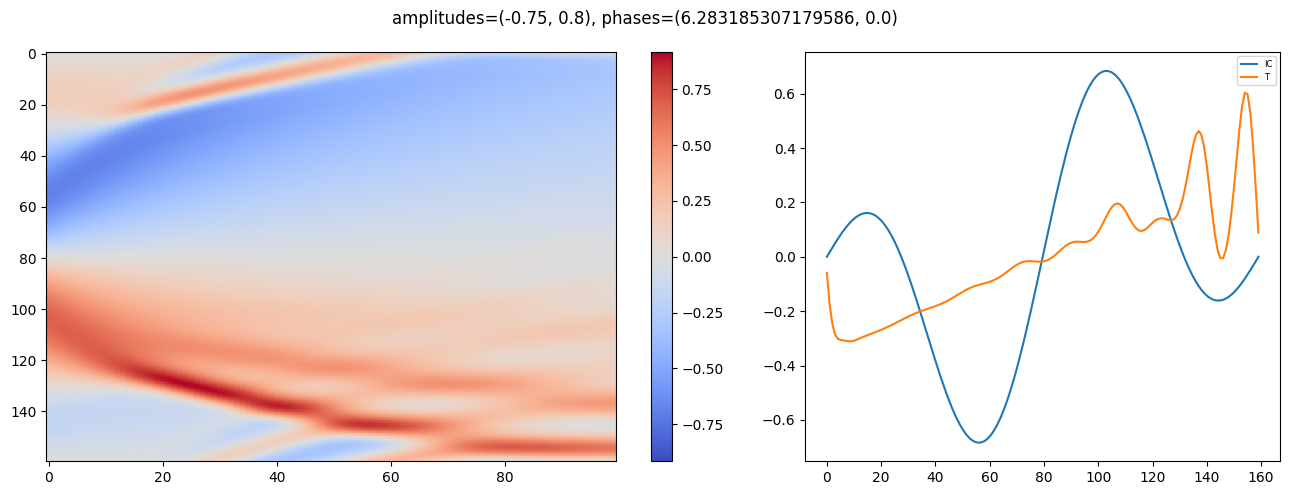

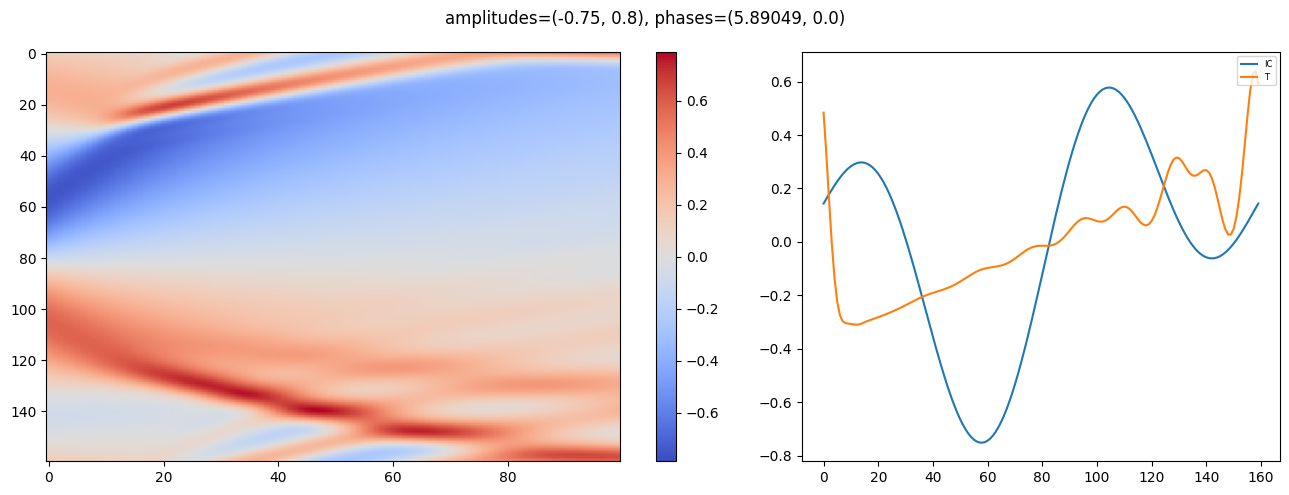

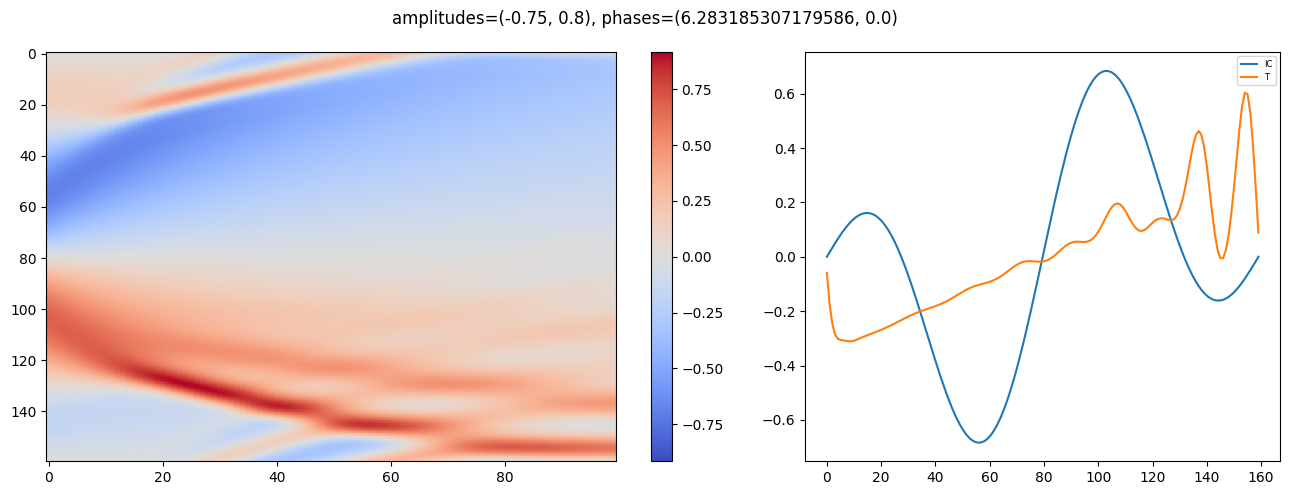

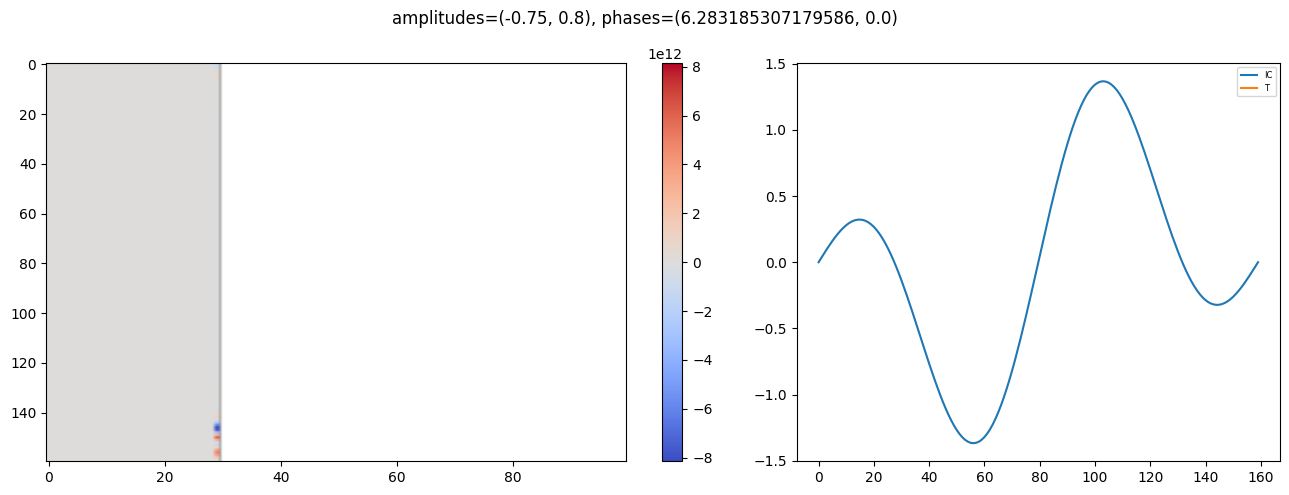

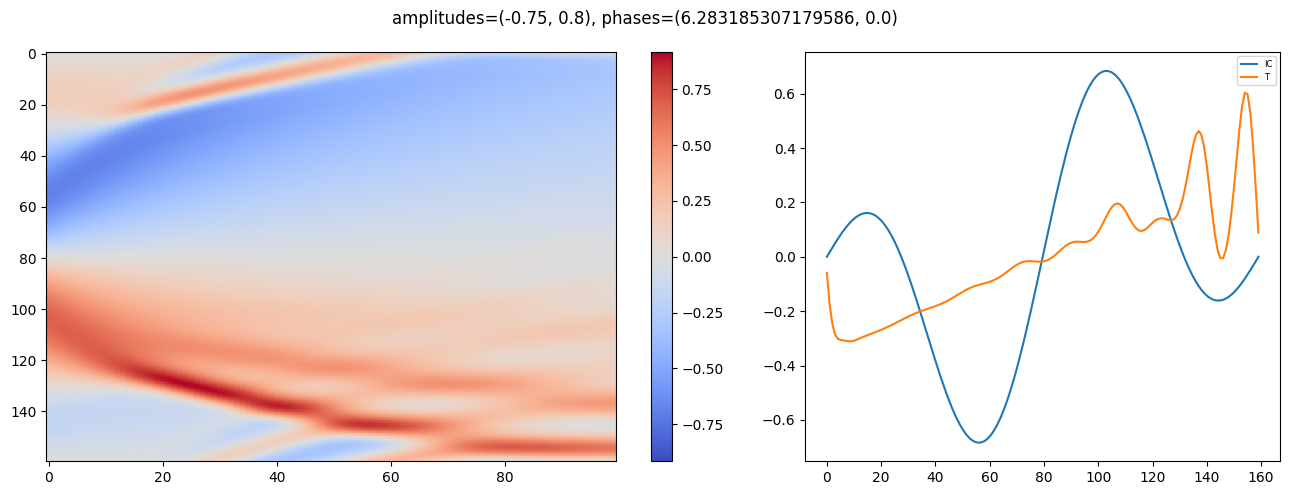

In [ ]:
run_widget(2,2)